In [1]:
import sys
sys.path.append('..')

import os
import pandas as pd
import numpy as np
import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import nn

from utils import get_device, train_clf, eval_clf, test_clf
from RoBertaClassifier import RoBertaClassifier, init_roberta_clf

/home/giacomo/mambaforge/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-04-25 23:47:25.168063: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Analyze dataset

In [2]:
texts_df = pd.read_csv('subtaskA_train.csv')

In [3]:
texts_df.head()

,Id,comment_text,conspiratorial
0,0,⚡Se non ci fossero soldati non ci sarebbero gu...,0
1,1,"21/08/21]( [PRE-PRINT]\n\n📄__ ""Shedding of Inf...",1
2,2,PAURA E DELIRIO ALLA CNN: IL MINISTERO DELLA V...,1
3,3,L'Aspirina non aumenta la sopravvivenza dei pa...,0
4,4,L'Italia non puo' dare armi lo vieta la Costit...,0


In [4]:
texts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1842 entries, 0 to 1841
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              1842 non-null   int64 
 1   comment_text    1842 non-null   object
 2   conspiratorial  1842 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 43.3+ KB


In [5]:
texts_df.conspiratorial.value_counts()

1    925
0    917
Name: conspiratorial, dtype: int64

### Test set

In [6]:
texts_df_test = pd.read_csv('subtaskA_test.csv')
texts_df_test.head()

,Id,comment_text
0,0,La CNN ha appena ammesso che Trump non è più a...
1,1,"Notizia del 2017: “Autovelox, la foto viola la..."
2,2,"La foto di due ""sospetti"" in un palazzo non è ..."
3,3,La falsa notizia della bambina con il cartello...
4,4,Ah dimenticavo.. e' gratuita


In [7]:
texts_df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            460 non-null    int64 
 1   comment_text  460 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.3+ KB


## Preprocessing

Remove break line characthers

In [8]:
texts_df.comment_text = texts_df.comment_text.apply(lambda text: text.replace('\n\n', ' ').replace('\n', ' '))
texts_df_test.comment_text = texts_df_test.comment_text.apply(lambda text: str(text).replace('\n\n', ' ').replace('\n', ' '))

## Train-Validation split

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

80-20 train-validation split of the labeled tr dataset

In [10]:
# Split the data into training and testing datasets using stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, eval_index in split.split(texts_df, texts_df.conspiratorial):
    train_df, val_df = texts_df.iloc[train_index], texts_df.iloc[eval_index]

In [11]:
print(train_df.info())
print(train_df.conspiratorial.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1473 entries, 1509 to 1768
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              1473 non-null   int64 
 1   comment_text    1473 non-null   object
 2   conspiratorial  1473 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 46.0+ KB
None
1    740
0    733
Name: conspiratorial, dtype: int64


In [12]:
print(val_df.info())
print(val_df.conspiratorial.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 361 to 667
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              369 non-null    int64 
 1   comment_text    369 non-null    object
 2   conspiratorial  369 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 11.5+ KB
None
1    185
0    184
Name: conspiratorial, dtype: int64


## Tokenization

In [13]:
from transformers import AutoTokenizer

In [14]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

In [15]:
texts_tr = train_df['comment_text']
labels_tr = train_df['conspiratorial'].to_numpy()

texts_val = val_df['comment_text']
labels_val = val_df['conspiratorial'].to_numpy()

texts_test = texts_df_test['comment_text']

Observe distribution of tokenized texts lengths by trying a simple tokenization on both tr and val sets.

Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors


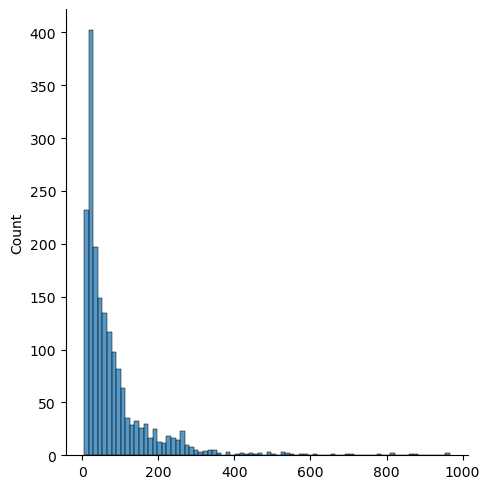

In [16]:
tokenized_len_list = []

for sentence in texts_tr:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))
for sentence in texts_val:
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)
    tokenized_len_list.append(len(input_ids))

sns.displot(tokenized_len_list)
plt.show()

The maximum tokenized length is above the RoBERTa max_lenght limit of 512. Very few texts are above this limit, so we truncate to 512

In [17]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

# Tr set
input_ids_tr = []
attention_masks_tr = []
max_sentence_len = 256

# `encode_plus` will:
#   1. Tokenize the sentence, 2. Prepend the `[CLS]` token to the start, 3. Append the `[SEP]` token to the end
#   4. Map tokens to their IDs, 5. Pad or truncate the sentence to `max_length`, 6. Create attention masks for [PAD] tokens
for sentence in texts_tr:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_sentence_len,
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_tr.append(encoded_dict['input_ids'])
    attention_masks_tr.append(encoded_dict['attention_mask'])

# Val set
input_ids_val = []
attention_masks_val = []

for sentence in texts_val:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_sentence_len,
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_val.append(encoded_dict['input_ids'])
    attention_masks_val.append(encoded_dict['attention_mask'])

# Test set
input_ids_test = []
attention_masks_test = []

for sentence in texts_test:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_sentence_len,
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence and attention mask to the list.    
    input_ids_test.append(encoded_dict['input_ids'])
    attention_masks_test.append(encoded_dict['attention_mask'])

In [18]:
# Convert the lists into tensors

input_ids_tr = torch.cat(input_ids_tr, dim=0)
input_ids_val = torch.cat(input_ids_val, dim=0)
input_ids_test = torch.cat(input_ids_test, dim=0)

attention_masks_tr = torch.cat(attention_masks_tr, dim=0)
attention_masks_val = torch.cat(attention_masks_val, dim=0)
attention_masks_test = torch.cat(attention_masks_test, dim=0)

labels_tr = torch.tensor(labels_tr)
labels_val = torch.tensor(labels_val)

## Generate DataLoaders

In [19]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

Wrap data into a TensorDataset

In [20]:
tr_dataset = TensorDataset(input_ids_tr, attention_masks_tr, labels_tr)
val_dataset = TensorDataset(input_ids_val, attention_masks_val, labels_val)
test_dataset = TensorDataset(input_ids_test, attention_masks_test)

The DataLoader needs to know our batch size for training. For fine-tuning RoBERTa on a specific task, a batch size of 16 or 32 is reccomended.

In [21]:
batch_size = 6

Create the DataLoaders for our training and validation sets. Tr samples are taken in random order, while validation are taken sequentially.

In [22]:
tr_dataloader = DataLoader(tr_dataset, sampler=RandomSampler(tr_dataset), batch_size = batch_size)

val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size = batch_size)

test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size = batch_size)

## Training Grid Search

In [23]:
device = get_device()

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [24]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

Set save folder for this run

In [25]:
from datetime import datetime
curr_date = datetime.now()

print(datetime.now())

save_folder_pth = './checkpoints_roberta_subtaskA/{}_{}_{}-{}.{}'.format(curr_date.day, curr_date.month, curr_date.year, curr_date.hour, curr_date.minute)
if not os.path.exists(save_folder_pth):
    os.makedirs(save_folder_pth)

2023-04-25 23:47:32.386057


Fixed general hyperparams

In [26]:
max_epochs = 12

# Num batches*num epochs
tr_steps = len(tr_dataloader)*max_epochs
warmup_steps = 0.05*tr_steps

Variable grid searched hyperparams (smaller grid search because of time and size constraints)

In [27]:
lr_list = [4e-6, 6e-6]
clf_head_list = []

head2 = nn.Sequential(
                nn.Linear(1024, 768),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(768, 2),
                )
clf_head_list.append((head2, '2_layers_L')) # Each head obeject is composed by a tuple (head, name)

head3 = nn.Sequential(
                nn.Linear(1024, 1024),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1024, 64),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(64, 2),
                )
clf_head_list.append((head3, '3_layers_L'))

Initialize, train/eval and save function for each grid search run

In [28]:
def train_eval_model(lr, warmup_steps, head, model_folder_pth, device):

    torch.cuda.empty_cache()
    #print(torch.cuda.memory_summary())

    # Initialize model
    roberta_clf_model, loss_function, optimizer, scheduler = init_roberta_clf(tr_steps=tr_steps, lr_rate=lr, scheduler_warmp_steps=warmup_steps, head=head)

    for epoch_i in range(max_epochs):
        print('Epoch: {}'.format(epoch_i))

        # Train
        avg_epoch_loss_tr, acc_score_tr, f1_score_tr, roberta_clf_model, optimizer, scheduler = train_clf(roberta_clf_model, tr_dataloader, loss_function, optimizer, scheduler, device)


        print('TRAINING | Tr Loss: {} - Tr acc: {} - Tr f1: {}'.format(avg_epoch_loss_tr, acc_score_tr, f1_score_tr))

        # Eval
        avg_epoch_loss_val, acc_score_val, f1_score_val, predictions, labels = eval_clf(roberta_clf_model, val_dataloader, loss_function, device)
        print('EVALUATION | Val Loss: {} - Val acc: {} - Val f1: {}'.format(avg_epoch_loss_val, acc_score_val, f1_score_val))

        # Save
        model_save_pth = os.path.join(model_folder_pth, 'roberta_clf_{}.pt'.format(epoch_i))
        torch.save({
                    'epoch': epoch_i,
                    'model_state_dict': roberta_clf_model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'schdeduler_state_dict': scheduler.state_dict(),
                    'tr_loss': avg_epoch_loss_tr,
                    'val_loss': avg_epoch_loss_val,
                    'tr_acc': acc_score_tr,
                    'val_acc': acc_score_val,
                    'tr_f1': f1_score_tr,
                    'val_f1': f1_score_val,
                    'val_preds': predictions
                    }, model_save_pth)

    torch.cuda.empty_cache()


Grid Search loop

In [29]:
num_trials = len(lr_list) * len(clf_head_list)
print('Executing {} trials in grid search'.format(num_trials))


for lr in lr_list:
    for clf_head_tuple in clf_head_list:            
            # Model save path subfolder
            model_folder_str = 'lr{}_head_{}'.format(lr, clf_head_tuple[1])
            model_folder_pth = os.path.join(save_folder_pth, model_folder_str)
            if not os.path.exists(model_folder_pth):
                os.makedirs(model_folder_pth)

            print()
            print('Executing model with lr={}, head={}'.format(lr, clf_head_tuple[1]))

            train_eval_model(lr, warmup_steps=warmup_steps, head=clf_head_tuple[0], model_folder_pth=model_folder_pth, device=device)

Executing 4 trials in grid search

Executing model with lr=4e-06, head=2_layers_L


Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0
TRAINING | Tr Loss: 0.6889225102779342 - Tr acc: 0.5356415478615071 - Tr f1: 0.4908265782611333
EVALUATION | Val Loss: 0.653403018751452 - Val acc: 0.5907859078590786 - Val f1: 0.5884160529484328
Epoch: 1
TRAINING | Tr Loss: 0.655053159691454 - Tr acc: 0.6272912423625254 - Tr f1: 0.626751771098679
EVALUATION | Val Loss: 0.6222336393210196 - Val acc: 0.6639566395663956 - Val f1: 0.6525001518925815
Epoch: 2
TRAINING | Tr Loss: 0.636716351882229 - Tr acc: 0.6625933469110659 - Tr f1: 0.6615951619009406
EVALUATION | Val Loss: 0.5652348081911763 - Val acc: 0.7154471544715447 - Val f1: 0.710955276213212
Epoch: 3
TRAINING | Tr Loss: 0.5527783482055354 - Tr acc: 0.7393075356415478 - Tr f1: 0.7382186546607031
EVALUATION | Val Loss: 0.5353708311675056 - Val acc: 0.7425474254742548 - Val f1: 0.7408343868520859
Epoch: 4
TRAINING | Tr Loss: 0.48931601337664493 - Tr acc: 0.7854718262050238 - Tr f1: 0.785388641552722
EVALUATION | Val Loss: 0.5987528080060598 - Val acc: 0.7777777777777778 - Va

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0
TRAINING | Tr Loss: 0.6686925379241385 - Tr acc: 0.5824847250509165 - Tr f1: 0.5824724093350817
EVALUATION | Val Loss: 0.6107544451951981 - Val acc: 0.7018970189701897 - Val f1: 0.6969810081223125
Epoch: 1
TRAINING | Tr Loss: 0.5798943607303185 - Tr acc: 0.7196198234894773 - Tr f1: 0.7189483240126677
EVALUATION | Val Loss: 0.5238879849353144 - Val acc: 0.7371273712737128 - Val f1: 0.7360106206438766
Epoch: 2
TRAINING | Tr Loss: 0.47992247826139617 - Tr acc: 0.7827562797012899 - Tr f1: 0.7827121156803523
EVALUATION | Val Loss: 0.5373981832977264 - Val acc: 0.7723577235772358 - Val f1: 0.7722222222222223
Epoch: 3
TRAINING | Tr Loss: 0.41266665471399705 - Tr acc: 0.845213849287169 - Tr f1: 0.8452132072341131
EVALUATION | Val Loss: 0.5581166776077401 - Val acc: 0.7804878048780488 - Val f1: 0.7804813560815823
Epoch: 4
TRAINING | Tr Loss: 0.3149528358182756 - Tr acc: 0.9063136456211812 - Tr f1: 0.9063011652776753
EVALUATION | Val Loss: 1.0861236887003836 - Val acc: 0.783197831978319

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0
TRAINING | Tr Loss: 0.6817969527186417 - Tr acc: 0.5648336727766463 - Tr f1: 0.5492365561264801
EVALUATION | Val Loss: 0.6414657985010455 - Val acc: 0.6747967479674797 - Val f1: 0.6735283708859265
Epoch: 1
TRAINING | Tr Loss: 0.5962902281463631 - Tr acc: 0.7080787508486083 - Tr f1: 0.7078739678112063
EVALUATION | Val Loss: 0.513823862758375 - Val acc: 0.7479674796747967 - Val f1: 0.747960075501076
Epoch: 2
TRAINING | Tr Loss: 0.47489842782327074 - Tr acc: 0.8092328581126952 - Tr f1: 0.8092103473977321
EVALUATION | Val Loss: 0.6985800409569375 - Val acc: 0.7506775067750677 - Val f1: 0.7505877512636652
Epoch: 3
TRAINING | Tr Loss: 0.418674724875018 - Tr acc: 0.8655804480651731 - Tr f1: 0.8655531215772181
EVALUATION | Val Loss: 0.6859333996150282 - Val acc: 0.7615176151761518 - Val f1: 0.7593525819647832
Epoch: 4
TRAINING | Tr Loss: 0.3845062833568043 - Tr acc: 0.9103869653767821 - Tr f1: 0.9103836198314197
EVALUATION | Val Loss: 1.2050712708395064 - Val acc: 0.7696476964769647 -

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: 0
TRAINING | Tr Loss: 0.6707374383278979 - Tr acc: 0.5852002715546504 - Tr f1: 0.557586989168291
EVALUATION | Val Loss: 0.6977790550839517 - Val acc: 0.6747967479674797 - Val f1: 0.6698872785829307
Epoch: 1
TRAINING | Tr Loss: 0.560607775106905 - Tr acc: 0.7325186693822132 - Tr f1: 0.731785747296423
EVALUATION | Val Loss: 0.6940064421824871 - Val acc: 0.6991869918699187 - Val f1: 0.6892454762717651
Epoch: 2
TRAINING | Tr Loss: 0.4637462676434619 - Tr acc: 0.8126272912423625 - Tr f1: 0.8123261971851792
EVALUATION | Val Loss: 0.6307881494923946 - Val acc: 0.7777777777777778 - Val f1: 0.7770557029177718
Epoch: 3
TRAINING | Tr Loss: 0.40514498567719737 - Tr acc: 0.8723693143245078 - Tr f1: 0.8723433679622069
EVALUATION | Val Loss: 1.083158646439833 - Val acc: 0.7208672086720868 - Val f1: 0.7104471244314763
Epoch: 4
TRAINING | Tr Loss: 0.3322543724183546 - Tr acc: 0.923285811269518 - Tr f1: 0.9232856698429524
EVALUATION | Val Loss: 1.379378266739584 - Val acc: 0.7425474254742548 - Va

## Analyze grid search results

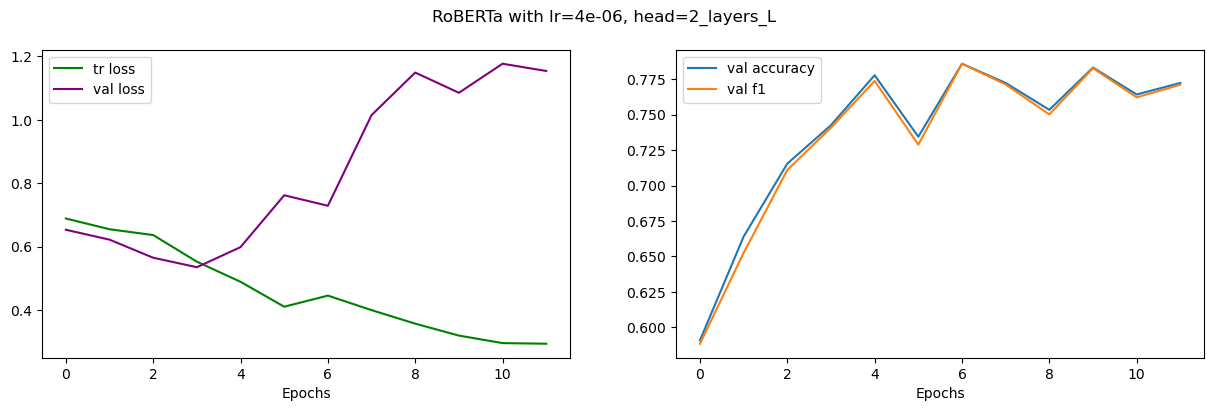

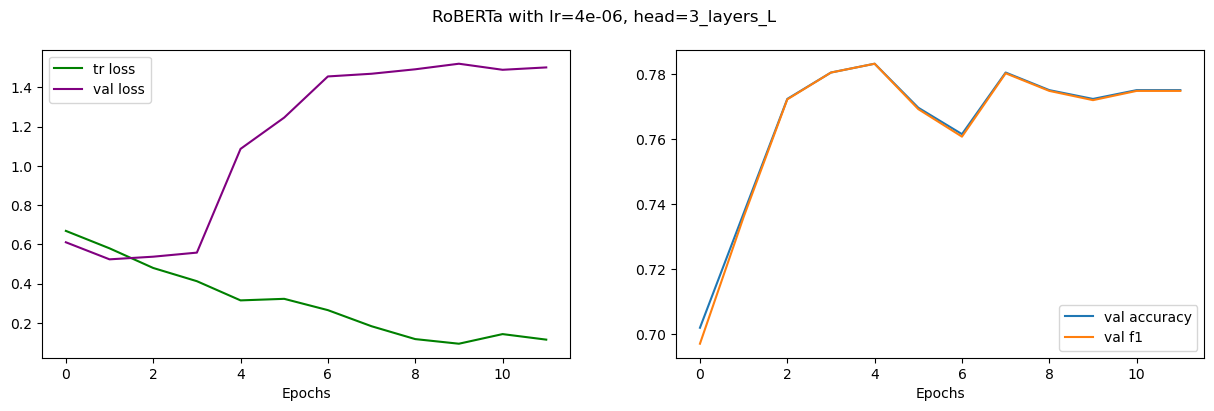

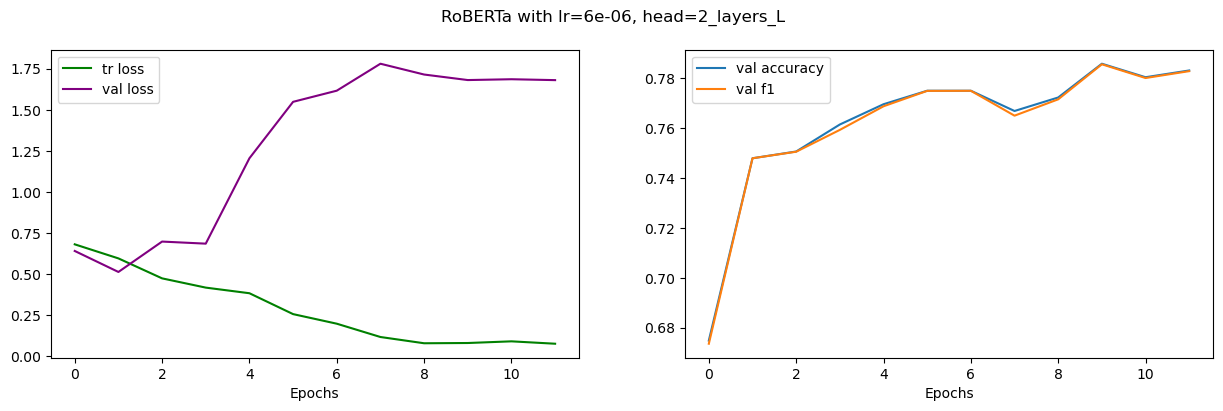

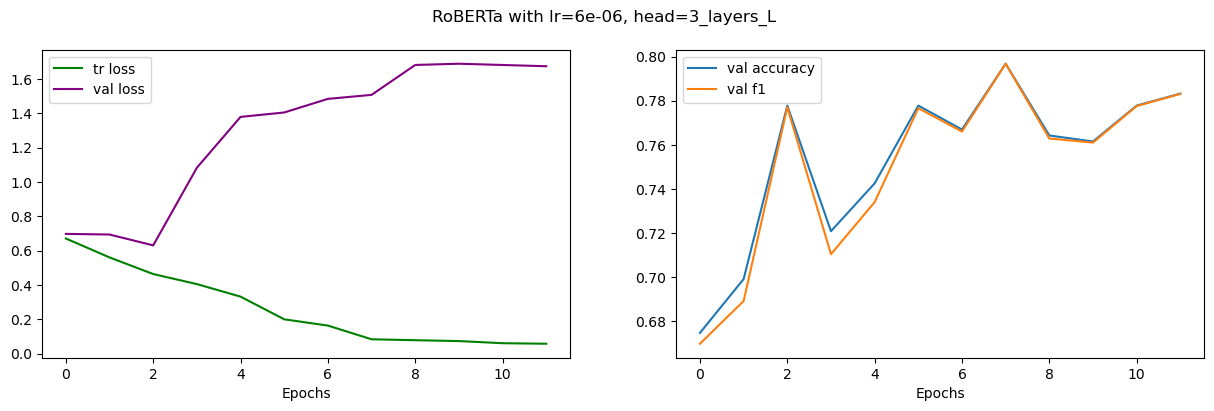

In [33]:
save_folder_pth = './checkpoints_roberta_subtaskA/25_4_2023-23.47' # Grid search run to analyze TO CHANGE


best_f1_list = []

for lr in lr_list:
    for clf_head_tuple in clf_head_list:
            
            # Model path subfolder
            model_folder_str = 'lr{}_head_{}'.format(lr, clf_head_tuple[1])
            model_folder_pth = os.path.join(save_folder_pth, model_folder_str)

            title = 'RoBERTa with lr={}, head={}'.format(lr, clf_head_tuple[1])

            # Load model checkpoint for each epoch
            val_loss_list, tr_loss_list, val_f1_list, val_acc_list = [], [], [], []

            for epoch_i in range(max_epochs):
                model_pth = os.path.join(model_folder_pth,'roberta_clf_{}.pt'.format(epoch_i))
                checkpoint = torch.load(model_pth)
                val_loss_list.append(checkpoint['val_loss'])
                tr_loss_list.append(checkpoint['tr_loss'])
                val_f1_list.append(checkpoint['val_f1'])
                val_acc_list.append(checkpoint['val_acc'])


            best_f1 = max(val_f1_list)
            best_epoch = val_f1_list.index(best_f1)
            best_f1_list.append((title, best_epoch, best_f1))


            plt.figure(figsize=(15,4))

            plt.subplot(1, 2, 1)
            plt.plot(tr_loss_list, label='tr loss', color='green')
            plt.plot(val_loss_list, label='val loss', color='purple')
            plt.xlabel('Epochs')
            plt.legend()

            plt.subplot(1,2,2)
            plt.plot(val_acc_list, label='val accuracy')
            plt.plot(val_f1_list, label='val f1')
            plt.xlabel('Epochs')
            plt.legend()

            plt.suptitle(title)
            plt.show()

In [34]:
for title, epoch, f1 in best_f1_list:
    print('{} at epoch {}, F1: {:.4f}'.format(title, epoch, f1))

RoBERTa with lr=4e-06, head=2_layers_L at epoch 6, F1: 0.7859
RoBERTa with lr=4e-06, head=3_layers_L at epoch 4, F1: 0.7832
RoBERTa with lr=6e-06, head=2_layers_L at epoch 9, F1: 0.7857
RoBERTa with lr=6e-06, head=3_layers_L at epoch 7, F1: 0.7967


## Choose and predict on test with best model

Best model is: RoBERTa with with lr=6e-06, head=3_layers_L at epoch 7, F1: 0.7967

In [35]:
device = get_device()

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3080 Ti Laptop GPU


In [36]:
final_model_pth = './checkpoints_roberta_subtaskA/25_4_2023-23.47/lr6e-06_head_3_layers_L/roberta_clf_7.pt'

# Recover the best head configuration
head_3_layers_L = nn.Sequential(
                nn.Linear(1024, 1024),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(1024, 64),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(64, 2),
                )
# Initialize and recover model checkpoint
final_model = RoBertaClassifier(head=head_3_layers_L)
final_model.load_state_dict(torch.load(final_model_pth).get('model_state_dict'))

final_model.to(device)

# Prediction on test
test_preds = test_clf(final_model, test_dataloader, device)

Some weights of the model checkpoint at xlm-roberta-large were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
print(test_preds)
# print occurrences of each class
print(np.unique(test_preds, return_counts=True))

[1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 

Generate result CSV

In [38]:
id_list = [i for i in range(len(test_preds))]
df = pd.DataFrame({'Id': id_list, 'Expected': test_preds})
df.to_csv('final_roberta_submission.csv', index=False)

**RESULTS FROM KAGGLE:**

On the 30% available hidden test set it scores **0.8255**  F1 macro averaged